In [33]:
import sys
sys.path.append('../core/')
sys.path.append('../networks/')
from simple_fc import Encoder, Decoder
from ssl_fc import SSL_Encoder1, SSL_Encoder2, SSL_Decoder
from vae import Variational_Autoencoder
from m2 import SSL_M2
from misc_ops import *

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from tensorflow.python.framework import dtypes
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
from dataset import DataSet
mnist = read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def split_data(dataset, num_labeled):
    """
    Split dataset into two datasets
    """
    n = dataset.num_examples
    x, y = dataset.next_batch(n)
    x1 = x[xrange(num_labeled),:]
    y1 = y[xrange(num_labeled),:]
    x2 = x[xrange(num_labeled, n),:]
    y2 = y[xrange(num_labeled, n),:]
    d1 = DataSet(x1, y1, dtype=dtypes.float32, reshape=False)
    d2 = DataSet(x2, y2, dtype=dtypes.float32, reshape=False)
    return d1, d2

In [4]:
# Split dataset into labeled and unlabeled
num_labeled = 20000
labeled, unlabeled = split_data(mnist.train, num_labeled)
_, y = labeled.next_batch(num_labeled)
print np.sum(y, axis=0)

[ 1993.  2286.  1962.  2099.  1910.  1801.  1961.  2047.  1926.  2015.]


In [69]:
tf.reset_default_graph()

In [27]:
# Train
sess = tf.InteractiveSession()
build_encoder = Encoder(600)
build_decoder = Decoder(600)

# as the number of labeled examples decreases, need alpha to decrease as well?
model = Variational_Autoencoder(sess, build_encoder, build_decoder, dataset=mnist.train,
            batch_size = 100, z_dim = 50, img_dim = 784,
           learning_rate = 1e-3, num_epochs = 50, load=False,
          checkpoint_name='SSL_M1_checkpoint'
)
model.train()

Epoch 1 loss: 164.477963257
Epoch 2 loss: 123.27263891
Epoch 3 loss: 114.89430431
Epoch 4 loss: 110.97631048
Epoch 5 loss: 108.385529771
Epoch 6 loss: 106.701016277
Epoch 7 loss: 105.290161299
Epoch 8 loss: 104.24427948
Epoch 9 loss: 103.273958185
Epoch 10 loss: 102.50923774
Epoch 11 loss: 101.844660603
Epoch 12 loss: 101.526396679
Epoch 13 loss: 100.919824579
Epoch 14 loss: 100.524474682
Epoch 15 loss: 100.252442128
Epoch 16 loss: 99.8614256425
Epoch 17 loss: 99.6540201499
Epoch 18 loss: 99.2656218511
Epoch 19 loss: 98.8730081454
Epoch 20 loss: 98.8856383584
Epoch 21 loss: 98.4381464594
Epoch 22 loss: 98.4586084262
Epoch 23 loss: 98.3014715021
Epoch 24 loss: 97.8070451494
Epoch 25 loss: 97.8543242992
Epoch 26 loss: 97.6115378085
Epoch 27 loss: 97.4463813504
Epoch 28 loss: 97.4667583258
Epoch 29 loss: 97.1520758334
Epoch 30 loss: 97.0142997187
Epoch 31 loss: 97.049370783
Epoch 32 loss: 96.7534930975
Epoch 33 loss: 96.7042869429
Epoch 34 loss: 96.6270896634
Epoch 35 loss: 96.3376609386


In [70]:
# Load
sess = tf.InteractiveSession()
build_encoder = Encoder(600)
build_decoder = Decoder(600)

# as the number of labeled examples decreases, need alpha to decrease as well?
model = Variational_Autoencoder(sess, build_encoder, build_decoder, dataset=mnist.train,
            batch_size = 100, z_dim = 50, img_dim = 784,
           learning_rate = 1e-3, num_epochs = 50, load=True,
          load_file = 'checkpoints/SSL_M1_checkpoint'
)


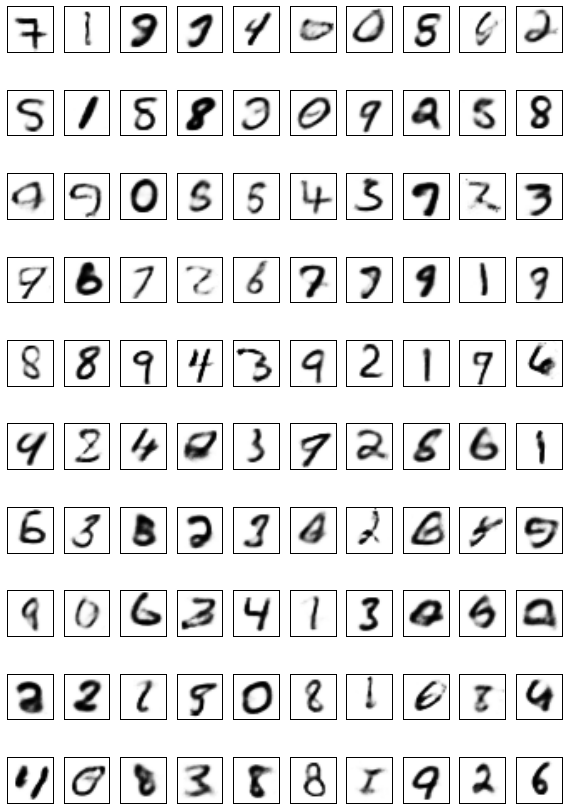

In [79]:
generated_images = model.generate(num=100)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(10):
        plt.subplot(10, 10, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
plt.show()

In [71]:
def split_data(dataset, num_labeled):
    """
    Split dataset into two datasets
    """
    n = dataset.num_examples
    x, y = dataset.next_batch(n)
    x1 = x[xrange(num_labeled),:]
    y1 = y[xrange(num_labeled),:]
    x2 = x[xrange(num_labeled, n),:]
    y2 = y[xrange(num_labeled, n),:]
    d1 = DataSet(x1, y1, dtype=dtypes.float32, reshape=False)
    d2 = DataSet(x2, y2, dtype=dtypes.float32, reshape=False)
    return d1, d2

In [72]:
# Split dataset into labeled and unlabeled
num_labeled = 50000
labeled, unlabeled = split_data(mnist.train, num_labeled)
_, y = labeled.next_batch(num_labeled)
print np.sum(y, axis=0)

[ 4942.  5629.  4959.  5163.  4840.  4539.  4889.  5178.  4893.  4968.]


In [73]:
z_dim = 50
num_labeled = labeled.num_examples
code_labeled = np.zeros((num_labeled, z_dim))
for i in xrange(num_labeled/100):
    code_labeled[xrange(100*i, 100*(i+1)),] = model.get_code(labeled.images[xrange(100*i, 100*(i+1))])
code_labeled = np.concatenate((labeled.images, code_labeled), axis=1)

num_unlabeled = unlabeled.num_examples
code_unlabeled = np.zeros((num_unlabeled, z_dim))
for i in xrange(num_unlabeled/100):
    code_unlabeled[xrange(100*i, 100*(i+1)),] = model.get_code(unlabeled.images[xrange(100*i, 100*(i+1))])
code_unlabeled = np.concatenate((unlabeled.images, code_unlabeled), axis=1)
dat_labeled = DataSet(code_labeled, labeled.labels, dtype=dtypes.float32, reshape=False)
dat_unlabeled = DataSet(code_unlabeled, unlabeled.labels, dtype=dtypes.float32, reshape=False)

In [74]:
sess.close()
tf.reset_default_graph()

In [75]:
# Train
sess = tf.InteractiveSession()
build_encoder1 = SSL_Encoder1(100)
build_encoder2 = SSL_Encoder2(100)
build_decoder = SSL_Decoder(100)


model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, dat_labeled, dat_unlabeled,
            batch_size = 100, z_dim = 50, x_dim = 28*28+z_dim, y_dim=10, alpha=55000./10,
           learning_rate = 1e-4, num_epochs = 20, load=False,
          checkpoint_name='SSL_M1M2_checkpoint'
)
model.train()

Epoch 1 loss: 7484.9268573
Epoch 2 loss: 2805.81722424
Epoch 3 loss: 2252.89723364


AssertionError: Model diverged with loss = NaN

In [ ]:
#Load
sess = tf.InteractiveSession()
build_encoder1 = SSL_Encoder1(100)
build_encoder2 = SSL_Encoder2(100)
build_decoder = SSL_Decoder(100)

model = SSL_M2(sess, build_encoder1, build_encoder2, build_decoder, dat_labeled, dat_unlabeled,
            batch_size = 100, z_dim = 50, x_dim = 28*28+z_dim, y_dim=10, alpha=55000./10,
           learning_rate = 1e-5, num_epochs = 20, load=True,
        load_file = "checkpoints/SSL_M1M2_checkpoint"
              )

In [32]:
model.train()

Epoch 1 loss: 2379.99902124
Epoch 2 loss: 2372.3393114
Epoch 3 loss: 2293.03617712
Epoch 4 loss: 2278.6883811
Epoch 5 loss: 2222.43287573


AssertionError: Model diverged with loss = NaN

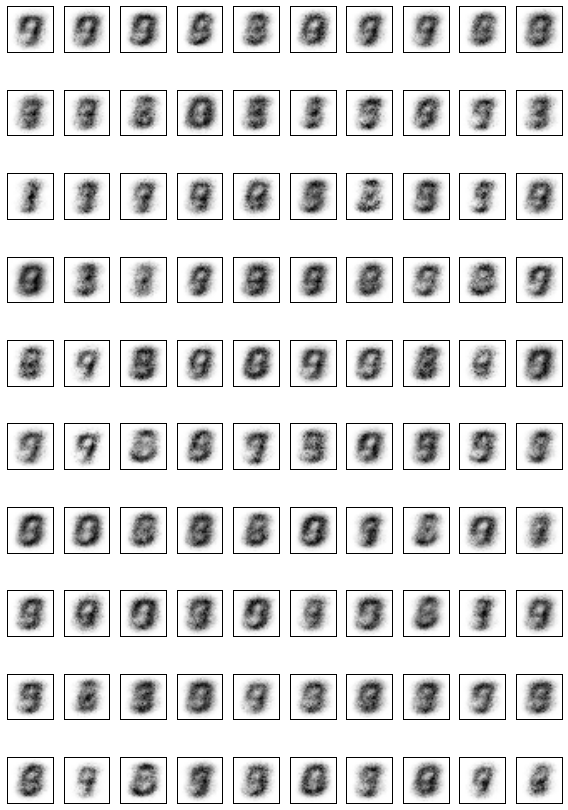

In [26]:
#images, info = mnist.test.next_batch(100)
num_examples = 10
batch_size = 100

labels = np.repeat(np.identity(10), num_examples, axis=0)
generated_images = model.generate(num=batch_size, labels=labels)


plt.figure(figsize=(8,12))
for i in xrange(10):
    for j in xrange(num_examples):
        plt.subplot(10, num_examples, 10*i+j+1)
        plt.imshow(generated_images[10*i+j,xrange(28*28)].reshape(28, 28), cmap='gray_r')
        plt.xticks([])
        plt.yticks([])
plt.tight_layout()
#plt.savefig('images/SSL_generate_10000')
plt.show()

In [75]:
# Classify validation images
batch_size = 100
num_val = mnist.validation.num_examples
tot = 0
for t in xrange(num_val / batch_size):
    x_val, y_val = mnist.validation.next_batch(batch_size)
    y_pred = model.classify(x_val)
    y_val = np.argmax(y_val, axis=1)
    tot += np.sum(y_pred != y_val)
print "Error: {}".format(float(tot)/num_val)
#with open("SSL_err_10000.txt", "w") as text_file:
    #text_file.write("Validation error: {}\n".format(float(tot)/num_val))

ValueError: Cannot feed value of shape (100, 784) for Tensor u'x_l:0', which has shape '(100, 834)'

In [ ]:
# Classify test images
batch_size = 100
num_test = mnist.test.num_examples
tot = 0
for t in xrange(num_test / batch_size):
    x_test, y_test = mnist.test.next_batch(batch_size)
    y_pred = model.classify(x_test)
    y_test = np.argmax(y_test, axis=1)
    tot += np.sum(y_pred != y_test)
print "Error: {}".format(float(tot)/num_test)
#with open("SSL_err_10000.txt", "a") as text_file:
    #text_file.write("Test error: {}".format(float(tot)/num_test))